# Lending Club 전처리 파이프라인 (Jupyter 버전)

## 목표
- scikit-learn 기반 전처리 파이프라인을 Jupyter 노트북으로 구현
- 각 단계별 결과 확인 및 시각화
- 모듈화된 전처리 과정

## 파이프라인 순서
1. **데이터 로드** (DataLoader)
2. **데이터 정제** (AnomalousRowRemover, TargetVariableCreator)
3. **데이터 변형** (PercentageCleaner, FICOFeatureCreator)
4. **결측치 처리** (HighMissingValueHandler, FinalMissingValueHandler)
5. **범주형 인코딩** (CategoricalEncoder, TargetEncoder, OneHotEncoder)
6. **이상치 처리** (OutlierHandler)
7. **특성 생성** (TimeFeatureCreator, CompositeFeatureCreator, FinancialFeatureCreator)
8. **특성 선택** (FeatureSelector, UnnecessaryFeatureRemover)
9. **스케일링** (Scaler)
10. **불균형 처리** (ImbalanceHandler, SMOTEHandler)

---

## 1단계: 기본 클래스들 (독립적)
DataLoader → AnomalousRowRemover → TargetVariableCreator

## 1. 환경 설정 및 라이브러리 Import

In [1]:
"""
scikit-learn 기반 전처리 파이프라인
기존 IntegratedPreprocessingPipeline을 scikit-learn 표준에 맞게 리팩토링

장점:
- fit/transform 패턴으로 일관된 인터페이스
- scikit-learn Pipeline과 호환
- 재사용성과 확장성 향상
- 표준화된 파라미터 관리
"""

import pandas as pd
import numpy as np
import warnings
import sys
import os
import time
from datetime import datetime
from pathlib import Path
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
import pickle

# 경고 무시
warnings.filterwarnings('ignore')

# 프로젝트 루트 경로 추가
sys.path.append(os.path.join(os.path.dirname('.'), '..'))

from config.file_paths import (
    SAMPLE_DATA_PATH,
    REPORTS_DIR,
    ensure_directory_exists
)

print("✅ 환경 설정 완료")
print(f"📁 데이터 경로: {SAMPLE_DATA_PATH}")
print(f"📁 결과 저장 경로: {REPORTS_DIR}")

⚠️ .env 파일이 없습니다. 기본 설정값을 사용합니다.
✅ 환경 설정 완료
📁 데이터 경로: /Users/tykim/Desktop/work/SNU_bigdata_fintech_2025/lending_club_project/feature_engineering/../data/lending_club_sample.csv
📁 결과 저장 경로: /Users/tykim/Desktop/work/SNU_bigdata_fintech_2025/lending_club_project/feature_engineering/../reports


## 2. DataLoader 클래스

In [2]:
class DataLoader(BaseEstimator, TransformerMixin):
    """데이터 로더 - scikit-learn 호환"""
    
    def __init__(self, data_path=None):
        self.data_path = data_path or SAMPLE_DATA_PATH
        
    def fit(self, X=None, y=None):
        return self
        
    def transform(self, X=None):
        """데이터 로드"""
        # X가 제공되면 그대로 반환 (파이프라인 내부에서 사용)
        if X is not None:
            return X
            
        # X가 없으면 파일에서 로드 (외부에서 직접 호출)
        try:
            df = pd.read_csv(self.data_path, low_memory=False)
            print(f"✓ 데이터 로드 완료: {df.shape}")
            return df
        except Exception as e:
            print(f"❌ 데이터 로드 실패: {e}")
            return None

print("✅ DataLoader 클래스 정의 완료")

✅ DataLoader 클래스 정의 완료


## PercentageCleaner 클래스

In [3]:
class PercentageCleaner(BaseEstimator, TransformerMixin):
    """퍼센트 컬럼 정리"""
    
    def __init__(self):
        self.percentage_columns = ['int_rate', 'revol_util']
        
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        for col in self.percentage_columns:
            if col in X.columns:
                try:
                    # 퍼센트 기호 제거 및 float 변환
                    X[col] = X[col].astype(str).str.replace('%', '').astype(float)
                    print(f"✓ {col}: 퍼센트 기호 제거 완료")
                except Exception as e:
                    print(f"⚠️ {col}: 변환 실패 - {e}")
        return X

print("✅ PercentageCleaner 클래스 정의 완료")

✅ PercentageCleaner 클래스 정의 완료


## FICOFeatureCreator 클래스

In [4]:
class FICOFeatureCreator(BaseEstimator, TransformerMixin):
    """FICO 특성 생성"""
    
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        # FICO 관련 컬럼 확인
        fico_columns = ['fico_range_low', 'fico_range_high', 
                       'last_fico_range_low', 'last_fico_range_high']
        
        available_fico_cols = [col for col in fico_columns if col in X.columns]
        
        if len(available_fico_cols) >= 2:
            # FICO 평균값 계산
            if 'fico_range_low' in X.columns and 'fico_range_high' in X.columns:
                X['fico_avg'] = (pd.to_numeric(X['fico_range_low'], errors='coerce') + 
                                pd.to_numeric(X['fico_range_high'], errors='coerce')) / 2
            
            if 'last_fico_range_low' in X.columns and 'last_fico_range_high' in X.columns:
                X['last_fico_avg'] = (pd.to_numeric(X['last_fico_range_low'], errors='coerce') + 
                                     pd.to_numeric(X['last_fico_range_high'], errors='coerce')) / 2
            
            # FICO 변화율 계산
            if 'fico_avg' in X.columns and 'last_fico_avg' in X.columns:
                X['fico_change'] = X['last_fico_avg'] - X['fico_avg']
                X['fico_change_rate'] = X['fico_change'] / (X['fico_avg'] + 1e-8)
            
            # FICO 구간화
            if 'fico_avg' in X.columns:
                fico_bins = list(range(300, 850, 50)) + [850]
                fico_labels = [f'{fico_bins[i]}-{fico_bins[i+1]-1}' for i in range(len(fico_bins)-1)]
                X['fico_range'] = pd.cut(X['fico_avg'], bins=fico_bins, labels=fico_labels, include_lowest=True)
            
            print(f"✓ FICO 특성 생성: 5개 특성")
        
        return X

print("✅ FICOFeatureCreator 클래스 정의 완료")

✅ FICOFeatureCreator 클래스 정의 완료


## 3. DataLoader 테스트

In [5]:
# DataLoader 테스트
print("🔍 DataLoader 테스트 시작")

# DataLoader 인스턴스 생성
data_loader = DataLoader()

# 데이터 로드 테스트
df = data_loader.transform(X=None)

if df is not None:
    print(f"✅ 데이터 로드 성공: {df.shape}")
    print(f"📊 데이터 정보:")
    print(f"  - 행 수: {df.shape[0]:,}개")
    print(f"  - 열 수: {df.shape[1]}개")
    print(f"  - 메모리 사용량: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    
    # 데이터 타입별 분포
    dtype_counts = df.dtypes.value_counts()
    print(f"\n📋 데이터 타입 분포:")
    for dtype, count in dtype_counts.items():
        print(f"  - {dtype}: {count}개")
    
    # 처음 5행 확인
    print(f"\n📋 처음 5행:")
    print(df.head())
    
    # 컬럼명 확인
    print(f"\n📋 컬럼명 (처음 10개):")
    print(df.columns[:10].tolist())
    
else:
    print("❌ 데이터 로드 실패")

🔍 DataLoader 테스트 시작
✓ 데이터 로드 완료: (1000, 141)
✅ 데이터 로드 성공: (1000, 141)
📊 데이터 정보:
  - 행 수: 1,000개
  - 열 수: 141개
  - 메모리 사용량: 2.48 MB

📋 데이터 타입 분포:
  - float64: 106개
  - object: 34개
  - int64: 1개

📋 처음 5행:
          id  loan_amnt  funded_amnt  funded_amnt_inv        term int_rate  \
0  133934806    10000.0      10000.0          10000.0   36 months   11.05%   
1  167504547    10000.0      10000.0          10000.0   36 months   17.74%   
2   75829857    28000.0      28000.0          28000.0   36 months    5.32%   
3   15620577    11000.0      11000.0          10950.0   36 months    8.90%   
4  167888994    23825.0      23825.0          23825.0   36 months   11.71%   

   installment grade sub_grade             emp_title  ... hardship_start_date  \
0       327.63     B        B4      Pharmacy Manager  ...                 NaN   
1       360.23     C        C5                   NaN  ...                 NaN   
2       843.22     A        A1  Financial Consultant  ...                 NaN   
3   

## 4. AnomalousRowRemover 클래스

In [6]:
class AnomalousRowRemover(BaseEstimator, TransformerMixin):
    """이상 로우 제거"""
    
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        if 'id' in X.columns:
            original_size = len(X)
            X = X[X['id'] != 'Loans that do not meet the credit policy'].copy()
            removed_count = original_size - len(X)
            print(f"✓ 이상 로우 제거: {removed_count}개")
        return X

print("✅ AnomalousRowRemover 클래스 정의 완료")

✅ AnomalousRowRemover 클래스 정의 완료


## 5. AnomalousRowRemover 테스트

In [7]:
# AnomalousRowRemover 테스트
print("🔍 AnomalousRowRemover 테스트 시작")

# AnomalousRowRemover 인스턴스 생성
anomalous_remover = AnomalousRowRemover()

# 이상 로우 제거 테스트
if df is not None:
    print(f"📊 처리 전 데이터 크기: {df.shape}")
    
    # 이상 로우 제거
    df_cleaned = anomalous_remover.fit_transform(df)
    
    print(f"📊 처리 후 데이터 크기: {df_cleaned.shape}")
    print(f"📊 제거된 행 수: {len(df) - len(df_cleaned)}개")
    
    # id 컬럼의 고유값 확인
    if 'id' in df_cleaned.columns:
        print(f"\n📋 id 컬럼 고유값:")
        print(df_cleaned['id'].value_counts().head())
    
    # 결과 저장 (다음 단계에서 사용)
    df = df_cleaned
    print("✅ 이상 로우 제거 완료")
else:
    print("❌ 데이터가 없어 테스트를 건너뜁니다.")

🔍 AnomalousRowRemover 테스트 시작
📊 처리 전 데이터 크기: (1000, 141)
✓ 이상 로우 제거: 0개
📊 처리 후 데이터 크기: (1000, 141)
📊 제거된 행 수: 0개

📋 id 컬럼 고유값:
id
133934806    1
1271385      1
132988582    1
156955041    1
51997460     1
Name: count, dtype: int64
✅ 이상 로우 제거 완료


## 6. TargetVariableCreator 클래스

In [8]:
class TargetVariableCreator(BaseEstimator, TransformerMixin):
    """타겟 변수 생성"""
    
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        loan_status_mapping = {
            'Fully Paid': 0, 'Current': 0, 'In Grace Period': 0,
            'Late (16-30 days)': 1, 'Late (31-120 days)': 1,
            'Charged Off': 1, 'Default': 1
        }
        
        X['target'] = X['loan_status'].map(loan_status_mapping)
        target_dist = X['target'].value_counts()
        print(f"✓ 타겟 변수 생성: 부도율 {target_dist[1]/len(X)*100:.2f}%")
        return X

print("✅ TargetVariableCreator 클래스 정의 완료")

✅ TargetVariableCreator 클래스 정의 완료


## 7. TargetVariableCreator 테스트

🔍 TargetVariableCreator 테스트 시작
📊 처리 전 데이터 크기: (1000, 141)

📊 원본 loan_status 분포:
  - Fully Paid: 514개 (51.40%)
  - Current: 354개 (35.40%)
  - Charged Off: 117개 (11.70%)
  - Late (31-120 days): 6개 (0.60%)
  - In Grace Period: 6개 (0.60%)
  - Late (16-30 days): 2개 (0.20%)
  - Does not meet the credit policy. Status:Fully Paid: 1개 (0.10%)
✓ 타겟 변수 생성: 부도율 12.50%

📊 처리 후 데이터 크기: (1000, 142)

🎯 타겟 변수 분포:
  - 정상 (0): 874개 (87.40%)
  - 부도 (1): 125개 (12.50%)


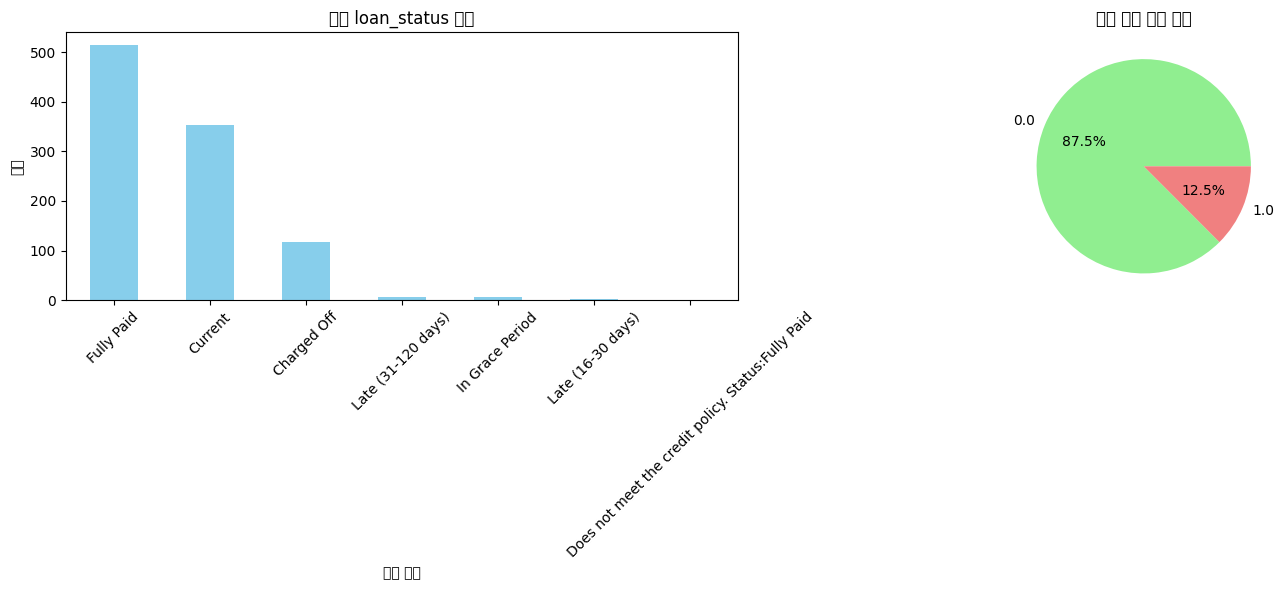

✅ 타겟 변수 생성 완료


In [9]:
# TargetVariableCreator 테스트
print("🔍 TargetVariableCreator 테스트 시작")

# TargetVariableCreator 인스턴스 생성
target_creator = TargetVariableCreator()

# 타겟 변수 생성 테스트
if df is not None and 'loan_status' in df.columns:
    print(f"📊 처리 전 데이터 크기: {df.shape}")
    
    # 원본 loan_status 분포 확인
    print(f"\n📊 원본 loan_status 분포:")
    loan_status_counts = df['loan_status'].value_counts()
    for status, count in loan_status_counts.items():
        percentage = (count / len(df)) * 100
        print(f"  - {status}: {count:,}개 ({percentage:.2f}%)")
    
    # 타겟 변수 생성
    df_with_target = target_creator.fit_transform(df)
    
    print(f"\n📊 처리 후 데이터 크기: {df_with_target.shape}")
    
    # 타겟 변수 분포 확인
    if 'target' in df_with_target.columns:
        target_dist = df_with_target['target'].value_counts()
        print(f"\n🎯 타겟 변수 분포:")
        print(f"  - 정상 (0): {target_dist[0]:,}개 ({(target_dist[0]/len(df_with_target)*100):.2f}%)")
        print(f"  - 부도 (1): {target_dist[1]:,}개 ({(target_dist[1]/len(df_with_target)*100):.2f}%)")
        
        # 시각화
        import matplotlib.pyplot as plt
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # 원본 loan_status
        loan_status_counts.plot(kind='bar', ax=ax1, color='skyblue')
        ax1.set_title('원본 loan_status 분포')
        ax1.set_xlabel('대출 상태')
        ax1.set_ylabel('개수')
        ax1.tick_params(axis='x', rotation=45)
        
        # 이진 타겟 변수
        target_dist.plot(kind='pie', ax=ax2, autopct='%1.1f%%', colors=['lightgreen', 'lightcoral'])
        ax2.set_title('이진 타겟 변수 분포')
        ax2.set_ylabel('')
        
        plt.tight_layout()
        plt.show()
    
    # 결과 저장 (다음 단계에서 사용)
    df = df_with_target
    print("✅ 타겟 변수 생성 완료")
else:
    print("❌ loan_status 컬럼이 없어 테스트를 건너뜁니다.")

## PercentageCleaner 테스트

In [10]:
# PercentageCleaner 테스트
print("🔍 PercentageCleaner 테스트 시작")

# PercentageCleaner 인스턴스 생성
percentage_cleaner = PercentageCleaner()

# 퍼센트 컬럼 정리 테스트
if df is not None:
    print(f"📊 처리 전 데이터 크기: {df.shape}")
    
    # 퍼센트 컬럼 확인
    percentage_cols = ['int_rate', 'revol_util']
    available_percentage_cols = [col for col in percentage_cols if col in df.columns]
    
    print(f"📋 처리할 퍼센트 컬럼: {available_percentage_cols}")
    
    for col in available_percentage_cols:
        print(f"\n📊 {col} 처리 전:")
        print(f"  - 데이터 타입: {df[col].dtype}")
        print(f"  - 샘플 값: {df[col].head(3).tolist()}")
        print(f"  - 고유값 수: {df[col].nunique()}")
    
    # 퍼센트 컬럼 정리
    df_cleaned = percentage_cleaner.fit_transform(df)
    
    print(f"\n📊 처리 후 데이터 크기: {df_cleaned.shape}")
    
    for col in available_percentage_cols:
        if col in df_cleaned.columns:
            print(f"\n📊 {col} 처리 후:")
            print(f"  - 데이터 타입: {df_cleaned[col].dtype}")
            print(f"  - 샘플 값: {df_cleaned[col].head(3).tolist()}")
            print(f"  - 최소값: {df_cleaned[col].min()}")
            print(f"  - 최대값: {df_cleaned[col].max()}")
    
    # 결과 저장 (다음 단계에서 사용)
    df = df_cleaned
    print("✅ 퍼센트 컬럼 정리 완료")
else:
    print("❌ 데이터가 없어 테스트를 건너뜁니다.")

🔍 PercentageCleaner 테스트 시작
📊 처리 전 데이터 크기: (1000, 142)
📋 처리할 퍼센트 컬럼: ['int_rate', 'revol_util']

📊 int_rate 처리 전:
  - 데이터 타입: object
  - 샘플 값: [' 11.05%', ' 17.74%', '  5.32%']
  - 고유값 수: 269

📊 revol_util 처리 전:
  - 데이터 타입: object
  - 샘플 값: ['69.4%', '76.5%', '32.2%']
  - 고유값 수: 600
✓ int_rate: 퍼센트 기호 제거 완료
✓ revol_util: 퍼센트 기호 제거 완료

📊 처리 후 데이터 크기: (1000, 142)

📊 int_rate 처리 후:
  - 데이터 타입: float64
  - 샘플 값: [11.05, 17.74, 5.32]
  - 최소값: 5.32
  - 최대값: 30.79

📊 revol_util 처리 후:
  - 데이터 타입: float64
  - 샘플 값: [69.4, 76.5, 32.2]
  - 최소값: 0.0
  - 최대값: 101.7
✅ 퍼센트 컬럼 정리 완료


## FICOFeatureCreator 테스트

�� FICOFeatureCreator 테스트 시작
📊 처리 전 데이터 크기: (1000, 142)
📋 사용 가능한 FICO 컬럼: ['fico_range_low', 'fico_range_high', 'last_fico_range_low', 'last_fico_range_high']

📊 fico_range_low:
  - 데이터 타입: float64
  - 샘플 값: [690.0, 660.0, 760.0]
  - 결측치: 0개

📊 fico_range_high:
  - 데이터 타입: float64
  - 샘플 값: [694.0, 664.0, 764.0]
  - 결측치: 0개

📊 last_fico_range_low:
  - 데이터 타입: float64
  - 샘플 값: [700.0, 720.0, 830.0]
  - 결측치: 0개

📊 last_fico_range_high:
  - 데이터 타입: float64
  - 샘플 값: [704.0, 724.0, 834.0]
  - 결측치: 0개
✓ FICO 특성 생성: 5개 특성

📊 처리 후 데이터 크기: (1000, 147)
📋 생성된 FICO 특성: ['fico_avg', 'last_fico_avg', 'fico_change', 'fico_change_rate', 'fico_range']

📊 fico_avg:
  - 데이터 타입: float64
  - 최소값: 662.0
  - 최대값: 847.5
  - 평균값: 702.97
  - 결측치: 0개

📊 last_fico_avg:
  - 데이터 타입: float64
  - 최소값: 249.5
  - 최대값: 832.0
  - 평균값: 685.55
  - 결측치: 0개

📊 fico_change:
  - 데이터 타입: float64
  - 최소값: -492.5
  - 최대값: 140.0
  - 평균값: -17.42
  - 결측치: 0개

📊 fico_change_rate:
  - 데이터 타입: float64
  - 최소값: -0.6637466307188175
  -

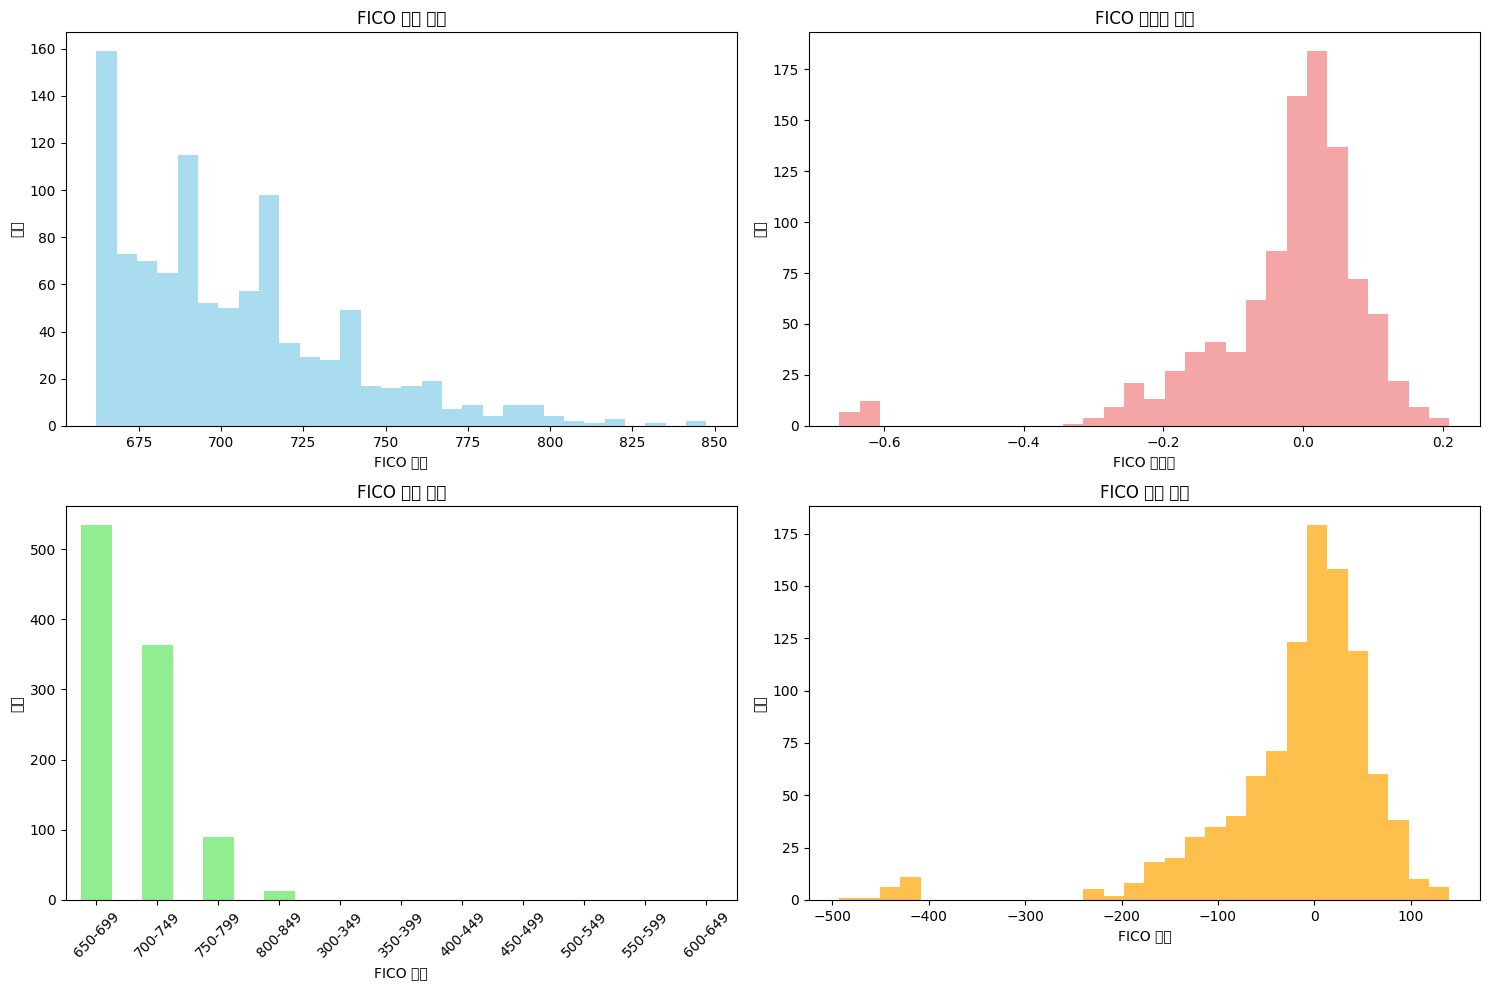

✅ FICO 특성 생성 완료


In [11]:
# FICOFeatureCreator 테스트
print("�� FICOFeatureCreator 테스트 시작")

# FICOFeatureCreator 인스턴스 생성
fico_creator = FICOFeatureCreator()

# FICO 특성 생성 테스트
if df is not None:
    print(f"📊 처리 전 데이터 크기: {df.shape}")
    
    # FICO 관련 컬럼 확인
    fico_columns = ['fico_range_low', 'fico_range_high', 
                   'last_fico_range_low', 'last_fico_range_high']
    available_fico_cols = [col for col in fico_columns if col in df.columns]
    
    print(f"📋 사용 가능한 FICO 컬럼: {available_fico_cols}")
    
    for col in available_fico_cols:
        print(f"\n📊 {col}:")
        print(f"  - 데이터 타입: {df[col].dtype}")
        print(f"  - 샘플 값: {df[col].head(3).tolist()}")
        print(f"  - 결측치: {df[col].isnull().sum()}개")
    
    # FICO 특성 생성
    df_with_fico = fico_creator.fit_transform(df)
    
    print(f"\n📊 처리 후 데이터 크기: {df_with_fico.shape}")
    
    # 새로 생성된 FICO 특성 확인
    new_fico_features = ['fico_avg', 'last_fico_avg', 'fico_change', 'fico_change_rate', 'fico_range']
    created_features = [col for col in new_fico_features if col in df_with_fico.columns]
    
    print(f"📋 생성된 FICO 특성: {created_features}")
    
    for feature in created_features:
        if feature in df_with_fico.columns:
            print(f"\n📊 {feature}:")
            if df_with_fico[feature].dtype in ['float64', 'int64']:
                print(f"  - 데이터 타입: {df_with_fico[feature].dtype}")
                print(f"  - 최소값: {df_with_fico[feature].min()}")
                print(f"  - 최대값: {df_with_fico[feature].max()}")
                print(f"  - 평균값: {df_with_fico[feature].mean():.2f}")
                print(f"  - 결측치: {df_with_fico[feature].isnull().sum()}개")
            else:
                print(f"  - 데이터 타입: {df_with_fico[feature].dtype}")
                print(f"  - 고유값: {df_with_fico[feature].nunique()}개")
                print(f"  - 결측치: {df_with_fico[feature].isnull().sum()}개")
    
    # FICO 특성 시각화
    if 'fico_avg' in df_with_fico.columns:
        import matplotlib.pyplot as plt
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # FICO 평균 분포
        axes[0, 0].hist(df_with_fico['fico_avg'].dropna(), bins=30, alpha=0.7, color='skyblue')
        axes[0, 0].set_title('FICO 평균 분포')
        axes[0, 0].set_xlabel('FICO 평균')
        axes[0, 0].set_ylabel('빈도')
        
        # FICO 변화율 분포
        if 'fico_change_rate' in df_with_fico.columns:
            axes[0, 1].hist(df_with_fico['fico_change_rate'].dropna(), bins=30, alpha=0.7, color='lightcoral')
            axes[0, 1].set_title('FICO 변화율 분포')
            axes[0, 1].set_xlabel('FICO 변화율')
            axes[0, 1].set_ylabel('빈도')
        
        # FICO 구간 분포
        if 'fico_range' in df_with_fico.columns:
            fico_range_counts = df_with_fico['fico_range'].value_counts()
            fico_range_counts.plot(kind='bar', ax=axes[1, 0], color='lightgreen')
            axes[1, 0].set_title('FICO 구간 분포')
            axes[1, 0].set_xlabel('FICO 구간')
            axes[1, 0].set_ylabel('개수')
            axes[1, 0].tick_params(axis='x', rotation=45)
        
        # FICO 변화 분포
        if 'fico_change' in df_with_fico.columns:
            axes[1, 1].hist(df_with_fico['fico_change'].dropna(), bins=30, alpha=0.7, color='orange')
            axes[1, 1].set_title('FICO 변화 분포')
            axes[1, 1].set_xlabel('FICO 변화')
            axes[1, 1].set_ylabel('빈도')
        
        plt.tight_layout()
        plt.show()
    
    # 결과 저장 (다음 단계에서 사용)
    df = df_with_fico
    print("✅ FICO 특성 생성 완료")
else:
    print("❌ 데이터가 없어 테스트를 건너뜁니다.")

## MissingValueHandler 클래스

In [13]:
class MissingValueHandler(BaseEstimator, TransformerMixin):
    """결측치 처리"""
    
    def __init__(self):
        self.missing_info = {}
        self.imputation_values = {}
        
    def fit(self, X, y=None):
        # 결측치 정보 수집
        for col in X.columns:
            missing_count = X[col].isnull().sum()
            missing_rate = missing_count / len(X) * 100
            self.missing_info[col] = {
                'missing_count': missing_count,
                'missing_rate': missing_rate
            }
        
        # 수치형 변수: 중앙값으로 대체
        numerical_cols = X.select_dtypes(include=[np.number]).columns.tolist()
        for col in numerical_cols:
            if col in X.columns and col != 'target':
                self.imputation_values[col] = X[col].median()
        
        # 범주형 변수: 최빈값으로 대체
        categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
        for col in categorical_cols:
            if col in X.columns:
                self.imputation_values[col] = X[col].mode().iloc[0] if not X[col].mode().empty else 'Unknown'
        
        return self
        
    def transform(self, X):
        # 결측치 처리
        for col in X.columns:
            if col in self.imputation_values:
                X[col] = X[col].fillna(self.imputation_values[col])
        
        # 결측치 처리 결과 출력
        total_missing = X.isnull().sum().sum()
        print(f"✓ 결측치 처리 완료: {total_missing}개 → 0개")
        
        return X

print("✅ MissingValueHandler 클래스 정의 완료")

✅ MissingValueHandler 클래스 정의 완료


## MissingValueHandler 테스트

In [14]:
# MissingValueHandler 테스트
print("🔍 MissingValueHandler 테스트 시작")

# MissingValueHandler 인스턴스 생성
missing_handler = MissingValueHandler()

# 결측치 처리 테스트
if df is not None:
    print(f"📊 처리 전 데이터 크기: {df.shape}")
    
    # 결측치 현황 확인
    missing_summary = df.isnull().sum()
    missing_cols = missing_summary[missing_summary > 0]
    
    print(f"�� 결측치가 있는 컬럼: {len(missing_cols)}개")
    for col, count in missing_cols.items():
        rate = count / len(df) * 100
        print(f"  - {col}: {count:,}개 ({rate:.2f}%)")
    
    # 결측치 처리
    df_imputed = missing_handler.fit_transform(df)
    
    print(f"\n📊 처리 후 데이터 크기: {df_imputed.shape}")
    
    # 결측치 처리 결과 확인
    remaining_missing = df_imputed.isnull().sum()
    remaining_missing_cols = remaining_missing[remaining_missing > 0]
    
    if len(remaining_missing_cols) == 0:
        print("✅ 모든 결측치가 처리되었습니다!")
    else:
        print(f"⚠️ 남은 결측치: {len(remaining_missing_cols)}개 컬럼")
        for col, count in remaining_missing_cols.items():
            print(f"  - {col}: {count}개")
    
    # 처리 방법 확인
    print(f"\n�� 사용된 대체값:")
    for col, value in missing_handler.imputation_values.items():
        if col in df.columns:
            print(f"  - {col}: {value}")
    
    # 결과 저장 (다음 단계에서 사용)
    df = df_imputed
    print("✅ 결측치 처리 완료")
else:
    print("❌ 데이터가 없어 테스트를 건너뜁니다.")

🔍 MissingValueHandler 테스트 시작
📊 처리 전 데이터 크기: (1000, 147)
�� 결측치가 있는 컬럼: 89개
  - emp_title: 85개 (8.50%)
  - emp_length: 68개 (6.80%)
  - title: 8개 (0.80%)
  - mths_since_last_delinq: 532개 (53.20%)
  - mths_since_last_record: 832개 (83.20%)
  - revol_util: 1개 (0.10%)
  - next_pymnt_d: 631개 (63.10%)
  - mths_since_last_major_derog: 766개 (76.60%)
  - annual_inc_joint: 931개 (93.10%)
  - dti_joint: 931개 (93.10%)
  - verification_status_joint: 933개 (93.30%)
  - tot_coll_amt: 24개 (2.40%)
  - tot_cur_bal: 24개 (2.40%)
  - open_acc_6m: 300개 (30.00%)
  - open_act_il: 300개 (30.00%)
  - open_il_12m: 300개 (30.00%)
  - open_il_24m: 300개 (30.00%)
  - mths_since_rcnt_il: 324개 (32.40%)
  - total_bal_il: 300개 (30.00%)
  - il_util: 395개 (39.50%)
  - open_rv_12m: 300개 (30.00%)
  - open_rv_24m: 300개 (30.00%)
  - max_bal_bc: 300개 (30.00%)
  - all_util: 300개 (30.00%)
  - total_rev_hi_lim: 24개 (2.40%)
  - inq_fi: 300개 (30.00%)
  - total_cu_tl: 300개 (30.00%)
  - inq_last_12m: 300개 (30.00%)
  - acc_open_past_24mths:

## OutlierHandler 클래스

In [15]:
class OutlierHandler(BaseEstimator, TransformerMixin):
    """이상치 처리"""
    
    def __init__(self, method='iqr', threshold=1.5):
        self.method = method
        self.threshold = threshold
        self.outlier_bounds = {}
        
    def fit(self, X, y=None):
        # 수치형 변수만 처리
        numerical_cols = X.select_dtypes(include=[np.number]).columns.tolist()
        if 'target' in numerical_cols:
            numerical_cols.remove('target')
        
        for col in numerical_cols:
            if col in X.columns:
                Q1 = X[col].quantile(0.25)
                Q3 = X[col].quantile(0.75)
                IQR = Q3 - Q1
                
                lower_bound = Q1 - self.threshold * IQR
                upper_bound = Q3 + self.threshold * IQR
                
                self.outlier_bounds[col] = {
                    'lower': lower_bound,
                    'upper': upper_bound,
                    'Q1': Q1,
                    'Q3': Q3,
                    'IQR': IQR
                }
        
        return self
        
    def transform(self, X):
        outlier_count = 0
        
        for col, bounds in self.outlier_bounds.items():
            if col in X.columns:
                # 이상치 개수 계산
                outliers = ((X[col] < bounds['lower']) | (X[col] > bounds['upper']))
                outlier_count += outliers.sum()
                
                # 이상치를 상한/하한값으로 클리핑
                X[col] = X[col].clip(lower=bounds['lower'], upper=bounds['upper'])
        
        print(f"✓ 이상치 처리 완료: {outlier_count}개 → 0개")
        return X

print("✅ OutlierHandler 클래스 정의 완료")

✅ OutlierHandler 클래스 정의 완료


## OutlierHandler 테스트

�� OutlierHandler 테스트 시작
📊 처리 전 데이터 크기: (1000, 147)
�� 처리할 수치형 변수: 113개
변수 목록: ['id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt', 'last_fico_range_high', 'last_fico_range_low', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'policy_code', 'annual_inc_joint', 'dti_joint', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m', 'acc_open_past_24mths

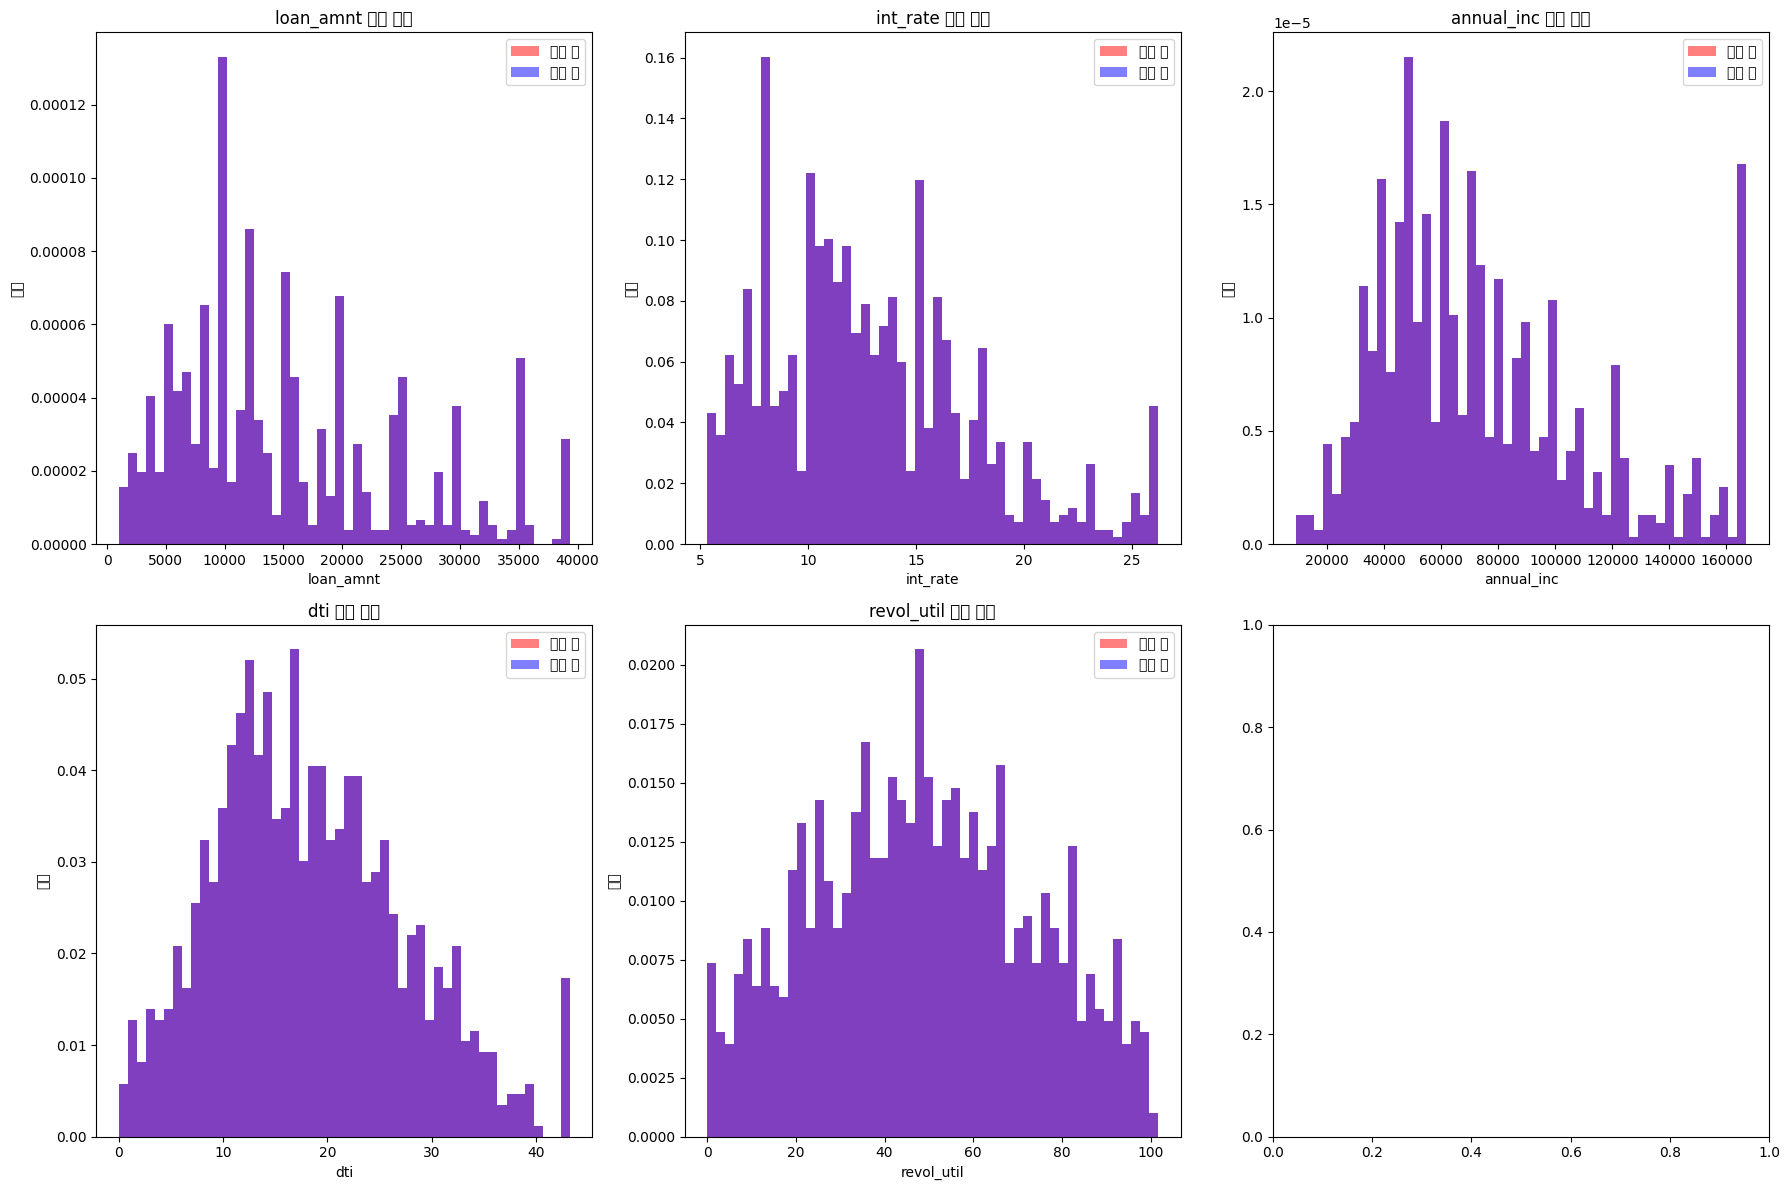

✅ 이상치 처리 완료


In [16]:
# OutlierHandler 테스트
print("�� OutlierHandler 테스트 시작")

# OutlierHandler 인스턴스 생성
outlier_handler = OutlierHandler(method='iqr', threshold=1.5)

# 이상치 처리 테스트
if df is not None:
    print(f"📊 처리 전 데이터 크기: {df.shape}")
    
    # 수치형 변수 확인
    numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if 'target' in numerical_cols:
        numerical_cols.remove('target')
    
    print(f"�� 처리할 수치형 변수: {len(numerical_cols)}개")
    print(f"변수 목록: {numerical_cols}")
    
    # 주요 수치형 변수 통계 (처리 전)
    key_vars = ['loan_amnt', 'int_rate', 'annual_inc', 'dti', 'revol_util']
    available_key_vars = [var for var in key_vars if var in df.columns]
    
    print(f"\n📊 처리 전 주요 변수 통계:")
    for var in available_key_vars:
        print(f"  {var}:")
        print(f"    - 최소값: {df[var].min():.2f}")
        print(f"    - 최대값: {df[var].max():.2f}")
        print(f"    - 평균값: {df[var].mean():.2f}")
        print(f"    - 중앙값: {df[var].median():.2f}")
    
    # 이상치 처리
    df_cleaned = outlier_handler.fit_transform(df)
    
    print(f"\n📊 처리 후 데이터 크기: {df_cleaned.shape}")
    
    # 이상치 처리 결과 확인
    print(f"\n📊 처리 후 주요 변수 통계:")
    for var in available_key_vars:
        if var in df_cleaned.columns:
            print(f"  {var}:")
            print(f"    - 최소값: {df_cleaned[var].min():.2f}")
            print(f"    - 최대값: {df_cleaned[var].max():.2f}")
            print(f"    - 평균값: {df_cleaned[var].mean():.2f}")
            print(f"    - 중앙값: {df_cleaned[var].median():.2f}")
    
    # 이상치 경계값 확인
    print(f"\n�� 이상치 경계값:")
    for col, bounds in outlier_handler.outlier_bounds.items():
        if col in available_key_vars:
            print(f"  {col}:")
            print(f"    - 하한값: {bounds['lower']:.2f}")
            print(f"    - 상한값: {bounds['upper']:.2f}")
            print(f"    - IQR: {bounds['IQR']:.2f}")
    
    # 이상치 처리 시각화
    if len(available_key_vars) > 0:
        import matplotlib.pyplot as plt
        
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        axes = axes.ravel()
        
        for i, var in enumerate(available_key_vars[:6]):
            if i < len(axes):
                # 처리 전후 비교
                axes[i].hist(df[var].dropna(), bins=50, alpha=0.5, color='red', label='처리 전', density=True)
                axes[i].hist(df_cleaned[var].dropna(), bins=50, alpha=0.5, color='blue', label='처리 후', density=True)
                axes[i].set_title(f'{var} 분포 비교')
                axes[i].set_xlabel(var)
                axes[i].set_ylabel('밀도')
                axes[i].legend()
        
        plt.tight_layout()
        plt.show()
    
    # 결과 저장 (다음 단계에서 사용)
    df = df_cleaned
    print("✅ 이상치 처리 완료")
else:
    print("❌ 데이터가 없어 테스트를 건너뜁니다.")

## OneHotEncoder 클래스

In [19]:
class OneHotEncoder(BaseEstimator, TransformerMixin):
    """원-핫 인코딩"""
    
    def __init__(self, max_categories=10):
        self.max_categories = max_categories
        self.categorical_columns = []
        self.encoding_mappings = {}
        
    def fit(self, X, y=None):
        # 범주형 변수 식별
        self.categorical_columns = X.select_dtypes(include=['object', 'category']).columns.tolist()
        
        # 각 범주형 변수에 대한 인코딩 매핑 생성
        for col in self.categorical_columns:
            if col in X.columns and col != 'target':
                value_counts = X[col].value_counts()
                
                # 최대 카테고리 수 제한
                if len(value_counts) > self.max_categories:
                    top_categories = value_counts.head(self.max_categories).index.tolist()
                    self.encoding_mappings[col] = top_categories
                else:
                    self.encoding_mappings[col] = value_counts.index.tolist()
        
        return self
        
    def transform(self, X):
        # 원-핫 인코딩 수행
        for col, categories in self.encoding_mappings.items():
            if col in X.columns:
                # 각 카테고리에 대해 더미 변수 생성
                for category in categories:
                    dummy_col_name = f"{col}_{category}"
                    X[dummy_col_name] = (X[col] == category).astype(int)
                
                # 원본 범주형 변수 제거
                X = X.drop(col, axis=1)
        
        print(f"✓ 원-핫 인코딩 완료: {len(self.categorical_columns)}개 변수")
        return X

print("✅ OneHotEncoder 클래스 정의 완료")

✅ OneHotEncoder 클래스 정의 완료


##  OneHotEncoder 테스트

In [20]:
# OneHotEncoder 테스트
print("🔍 OneHotEncoder 테스트 시작")

# OneHotEncoder 인스턴스 생성
onehot_encoder = OneHotEncoder(max_categories=10)

# 원-핫 인코딩 테스트
if df is not None:
    print(f"📊 처리 전 데이터 크기: {df.shape}")
    
    # 범주형 변수 확인
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    print(f"📋 범주형 변수: {len(categorical_cols)}개")
    print(f"변수 목록: {categorical_cols}")
    
    # 주요 범주형 변수 분포 확인
    key_categorical_vars = ['grade', 'home_ownership', 'verification_status', 'purpose']
    available_categorical_vars = [var for var in key_categorical_vars if var in df.columns]
    
    print(f"\n📊 처리 전 주요 범주형 변수 분포:")
    for var in available_categorical_vars:
        print(f"\n{var}:")
        value_counts = df[var].value_counts()
        print(f"  - 고유값 수: {len(value_counts)}개")
        print(f"  - 상위 5개 값:")
        for val, count in value_counts.head(5).items():
            rate = count / len(df) * 100
            print(f"    {val}: {count:,}개 ({rate:.2f}%)")
    
    # 원-핫 인코딩
    df_encoded = onehot_encoder.fit_transform(df)
    
    print(f"\n📊 처리 후 데이터 크기: {df_encoded.shape}")
    
    # 생성된 더미 변수 확인
    dummy_columns = [col for col in df_encoded.columns if '_' in col and any(cat in col for cat in available_categorical_vars)]
    print(f"📋 생성된 더미 변수: {len(dummy_columns)}개")
    
    # 주요 더미 변수 확인
    for var in available_categorical_vars[:3]:  # 처음 3개만
        var_dummies = [col for col in dummy_columns if col.startswith(f"{var}_")]
        print(f"\n{var} 더미 변수:")
        for dummy in var_dummies[:5]:  # 처음 5개만
            count = df_encoded[dummy].sum()
            rate = count / len(df_encoded) * 100
            print(f"  - {dummy}: {count:,}개 ({rate:.2f}%)")
    
    # 결과 저장 (다음 단계에서 사용)
    df = df_encoded
    print("✅ 원-핫 인코딩 완료")
else:
    print("❌ 데이터가 없어 테스트를 건너뜁니다.")

🔍 OneHotEncoder 테스트 시작
📊 처리 전 데이터 크기: (1000, 147)
📋 범주형 변수: 33개
변수 목록: ['term', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'verification_status', 'issue_d', 'loan_status', 'pymnt_plan', 'url', 'purpose', 'title', 'zip_code', 'addr_state', 'earliest_cr_line', 'initial_list_status', 'last_pymnt_d', 'next_pymnt_d', 'last_credit_pull_d', 'application_type', 'verification_status_joint', 'sec_app_earliest_cr_line', 'hardship_flag', 'hardship_type', 'hardship_reason', 'hardship_status', 'hardship_start_date', 'hardship_end_date', 'payment_plan_start_date', 'hardship_loan_status', 'debt_settlement_flag', 'fico_range']

📊 처리 전 주요 범주형 변수 분포:

grade:
  - 고유값 수: 7개
  - 상위 5개 값:
    B: 311개 (31.10%)
    C: 259개 (25.90%)
    A: 219개 (21.90%)
    D: 145개 (14.50%)
    E: 43개 (4.30%)

home_ownership:
  - 고유값 수: 4개
  - 상위 5개 값:
    MORTGAGE: 513개 (51.30%)
    RENT: 390개 (39.00%)
    OWN: 93개 (9.30%)
    ANY: 4개 (0.40%)

verification_status:
  - 고유값 수: 3개
  - 상위 5개 값:
    Source V

## LabelEncoder 클래스

In [23]:
class LabelEncoder(BaseEstimator, TransformerMixin):
    """라벨 인코딩"""
    
    def __init__(self):
        self.label_mappings = {}
        
    def fit(self, X, y=None):
        # 범주형 변수 식별 (원-핫 인코딩 후 남은 범주형 변수)
        categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
        
        for col in categorical_cols:
            if col in X.columns and col != 'target':
                unique_values = X[col].unique()
                # 알파벳 순으로 정렬하여 일관된 매핑 생성
                sorted_values = sorted(unique_values)
                self.label_mappings[col] = {val: idx for idx, val in enumerate(sorted_values)}
        
        return self
        
    def transform(self, X):
        # 라벨 인코딩 수행
        for col, mapping in self.label_mappings.items():
            if col in X.columns:
                X[col] = X[col].map(mapping)
                # 매핑되지 않은 값은 -1로 처리
                X[col] = X[col].fillna(-1).astype(int)
        
        print(f"✓ 라벨 인코딩 완료: {len(self.label_mappings)}개 변수")
        return X

print("✅ LabelEncoder 클래스 정의 완료")

# ================================
# LabelEncoder 테스트
print("🔍 LabelEncoder 테스트 시작")

# LabelEncoder 인스턴스 생성
label_encoder = LabelEncoder()

# 라벨 인코딩 테스트
if df is not None:
    print(f"📊 처리 전 데이터 크기: {df.shape}")
    
    # 남은 범주형 변수 확인
    remaining_categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    print(f"📋 라벨 인코딩할 범주형 변수: {len(remaining_categorical_cols)}개")
    print(f"변수 목록: {remaining_categorical_cols}")
    
    # 범주형 변수 분포 확인
    for col in remaining_categorical_cols[:3]:  # 처음 3개만
        if col in df.columns:
            print(f"\n📊 {col} 분포:")
            value_counts = df[col].value_counts()
            print(f"  - 고유값 수: {len(value_counts)}개")
            print(f"  - 상위 5개 값:")
            for val, count in value_counts.head(5).items():
                rate = count / len(df) * 100
                print(f"    {val}: {count:,}개 ({rate:.2f}%)")
    
    # 라벨 인코딩
    df_labeled = label_encoder.fit_transform(df)
    
    print(f"\n📊 처리 후 데이터 크기: {df_labeled.shape}")
    
    # 인코딩 결과 확인
    for col, mapping in label_encoder.label_mappings.items():
        if col in df_labeled.columns:
            print(f"\n📊 {col} 라벨 인코딩 결과:")
            print(f"  - 매핑: {mapping}")
            print(f"  - 데이터 타입: {df_labeled[col].dtype}")
            print(f"  - 최소값: {df_labeled[col].min()}")
            print(f"  - 최대값: {df_labeled[col].max()}")
            print(f"  - 고유값: {df_labeled[col].nunique()}개")
    
    # 결과 저장 (다음 단계에서 사용)
    df = df_labeled
    print("✅ 라벨 인코딩 완료")
else:
    print("❌ 데이터가 없어 테스트를 건너뜁니다.")

✅ LabelEncoder 클래스 정의 완료
🔍 LabelEncoder 테스트 시작
📊 처리 전 데이터 크기: (1000, 343)
📋 라벨 인코딩할 범주형 변수: 0개
변수 목록: []
✓ 라벨 인코딩 완료: 0개 변수

📊 처리 후 데이터 크기: (1000, 343)
✅ 라벨 인코딩 완료


## TargetEncoder 클래스

In [25]:
class TargetEncoder(BaseEstimator, TransformerMixin):
    """타겟 인코딩"""
    
    def __init__(self, smoothing=1.0):
        self.smoothing = smoothing
        self.target_means = {}
        
    def fit(self, X, y=None):
        if 'target' in X.columns:
            # 범주형 변수 식별
            categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
            
            for col in categorical_cols:
                if col in X.columns and col != 'target':
                    # 각 카테고리별 타겟 평균 계산
                    target_means = X.groupby(col)['target'].mean()
                    global_mean = X['target'].mean()
                    
                    # 스무딩 적용
                    smoothed_means = {}
                    for category in target_means.index:
                        count = (X[col] == category).sum()
                        smoothed_mean = (count * target_means[category] + self.smoothing * global_mean) / (count + self.smoothing)
                        smoothed_means[category] = smoothed_mean
                    
                    self.target_means[col] = smoothed_means
        
        return self
        
    def transform(self, X):
        for col, means in self.target_means.items():
            if col in X.columns:
                # 범주형 타입을 문자열로 변환
                if X[col].dtype.name == 'category':
                    X[col] = X[col].astype(str)
                
                # 타겟 인코딩 적용
                encoded_values = X[col].map(means)
                global_mean = X['target'].mean() if 'target' in X.columns else 0.125
                X[f'{col}_target_encoded'] = encoded_values.fillna(global_mean)
        
        print(f"✓ 타겟 인코딩 완료: {len(self.target_means)}개 변수")
        return X

print("✅ TargetEncoder 클래스 정의 완료")

# ================================
# TargetEncoder 테스트
print("🔍 TargetEncoder 테스트 시작")

# TargetEncoder 인스턴스 생성
target_encoder = TargetEncoder(smoothing=1.0)

# 타겟 인코딩 테스트
if df is not None and 'target' in df.columns:
    print(f"📊 처리 전 데이터 크기: {df.shape}")
    
    # 타겟 변수 분포 확인
    target_dist = df['target'].value_counts()
    print(f"📊 타겟 변수 분포:")
    print(f"  - 정상 (0): {target_dist[0]:,}개 ({(target_dist[0]/len(df)*100):.2f}%)")
    print(f"  - 부도 (1): {target_dist[1]:,}개 ({(target_dist[1]/len(df)*100):.2f}%)")
    
    # 범주형 변수 확인
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    available_categorical_cols = [col for col in categorical_cols if col in df.columns and col != 'target']
    
    print(f"\n📋 타겟 인코딩할 범주형 변수: {len(available_categorical_cols)}개")
    print(f"변수 목록: {available_categorical_cols}")
    
    # 주요 범주형 변수의 타겟 분포 확인
    key_vars = ['grade', 'home_ownership', 'verification_status']
    for var in key_vars:
        if var in available_categorical_cols:
            print(f"\n📊 {var} 타겟 분포:")
            target_by_category = df.groupby(var)['target'].agg(['count', 'mean'])
            target_by_category.columns = ['개수', '부도율']
            target_by_category['부도율'] = target_by_category['부도율'] * 100
            print(target_by_category.head())
    
    # 타겟 인코딩
    df_target_encoded = target_encoder.fit_transform(df)
    
    print(f"\n📊 처리 후 데이터 크기: {df_target_encoded.shape}")
    
    # 생성된 타겟 인코딩 변수 확인
    target_encoded_cols = [col for col in df_target_encoded.columns if col.endswith('_target_encoded')]
    print(f"📋 생성된 타겟 인코딩 변수: {len(target_encoded_cols)}개")
    
    for col in target_encoded_cols[:3]:  # 처음 3개만
        if col in df_target_encoded.columns:
            print(f"\n📊 {col}:")
            print(f"  - 최소값: {df_target_encoded[col].min():.4f}")
            print(f"  - 최대값: {df_target_encoded[col].max():.4f}")
            print(f"  - 평균값: {df_target_encoded[col].mean():.4f}")
            print(f"  - 표준편차: {df_target_encoded[col].std():.4f}")
    
    # 타겟 인코딩 결과 시각화
    if len(target_encoded_cols) > 0:
        import matplotlib.pyplot as plt
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        axes = axes.ravel()
        
        for i, col in enumerate(target_encoded_cols[:4]):
            if i < len(axes):
                axes[i].hist(df_target_encoded[col].dropna(), bins=30, alpha=0.7, color='lightgreen')
                axes[i].set_title(f'{col} 분포')
                axes[i].set_xlabel('타겟 인코딩 값')
                axes[i].set_ylabel('빈도')
        
        plt.tight_layout()
        plt.show()
    
    # 결과 저장 (다음 단계에서 사용)
    df = df_target_encoded
    print("✅ 타겟 인코딩 완료")
else:
    print("❌ 데이터가 없거나 타겟 변수가 없어 테스트를 건너뜁니다.")

✅ TargetEncoder 클래스 정의 완료
🔍 TargetEncoder 테스트 시작
📊 처리 전 데이터 크기: (1000, 343)
📊 타겟 변수 분포:
  - 정상 (0): 874개 (87.40%)
  - 부도 (1): 125개 (12.50%)

📋 타겟 인코딩할 범주형 변수: 0개
변수 목록: []
✓ 타겟 인코딩 완료: 0개 변수

📊 처리 후 데이터 크기: (1000, 343)
📋 생성된 타겟 인코딩 변수: 0개
✅ 타겟 인코딩 완료


## Scaler 클래스

✅ Scaler 클래스 정의 완료
�� Scaler 테스트 시작
📊 처리 전 데이터 크기: (1000, 343)
�� 스케일링할 수치형 변수: 342개

📊 처리 전 주요 변수 통계:
  loan_amnt:
    - 최소값: 1000.00
    - 최대값: 39328.12
    - 평균값: 15262.39
    - 표준편차: 9453.61
  int_rate:
    - 최소값: 5.32
    - 최대값: 26.22
    - 평균값: 12.94
    - 표준편차: 4.80
  annual_inc:
    - 최소값: 9000.00
    - 최대값: 167000.00
    - 평균값: 75085.63
    - 표준편차: 38032.94
  dti:
    - 최소값: 0.00
    - 최대값: 43.22
    - 평균값: 18.30
    - 표준편차: 9.09
  revol_util:
    - 최소값: 0.00
    - 최대값: 101.70
    - 평균값: 48.58
    - 표준편차: 24.52
✓ 스케일링 완료: 342개 변수 (standard)

📊 처리 후 데이터 크기: (1000, 343)

📊 처리 후 주요 변수 통계:
  loan_amnt:
    - 최소값: -1.5094
    - 최대값: 2.5469
    - 평균값: 0.0000
    - 표준편차: 1.0005
  int_rate:
    - 최소값: -1.5894
    - 최대값: 2.7672
    - 평균값: -0.0000
    - 표준편차: 1.0005
  annual_inc:
    - 최소값: -1.7385
    - 최대값: 2.4179
    - 평균값: -0.0000
    - 표준편차: 1.0005
  dti:
    - 최소값: -2.0148
    - 최대값: 2.7427
    - 평균값: 0.0000
    - 표준편차: 1.0005
  revol_util:
    - 최소값: -1.9826
    - 최대값: 2.1676
   

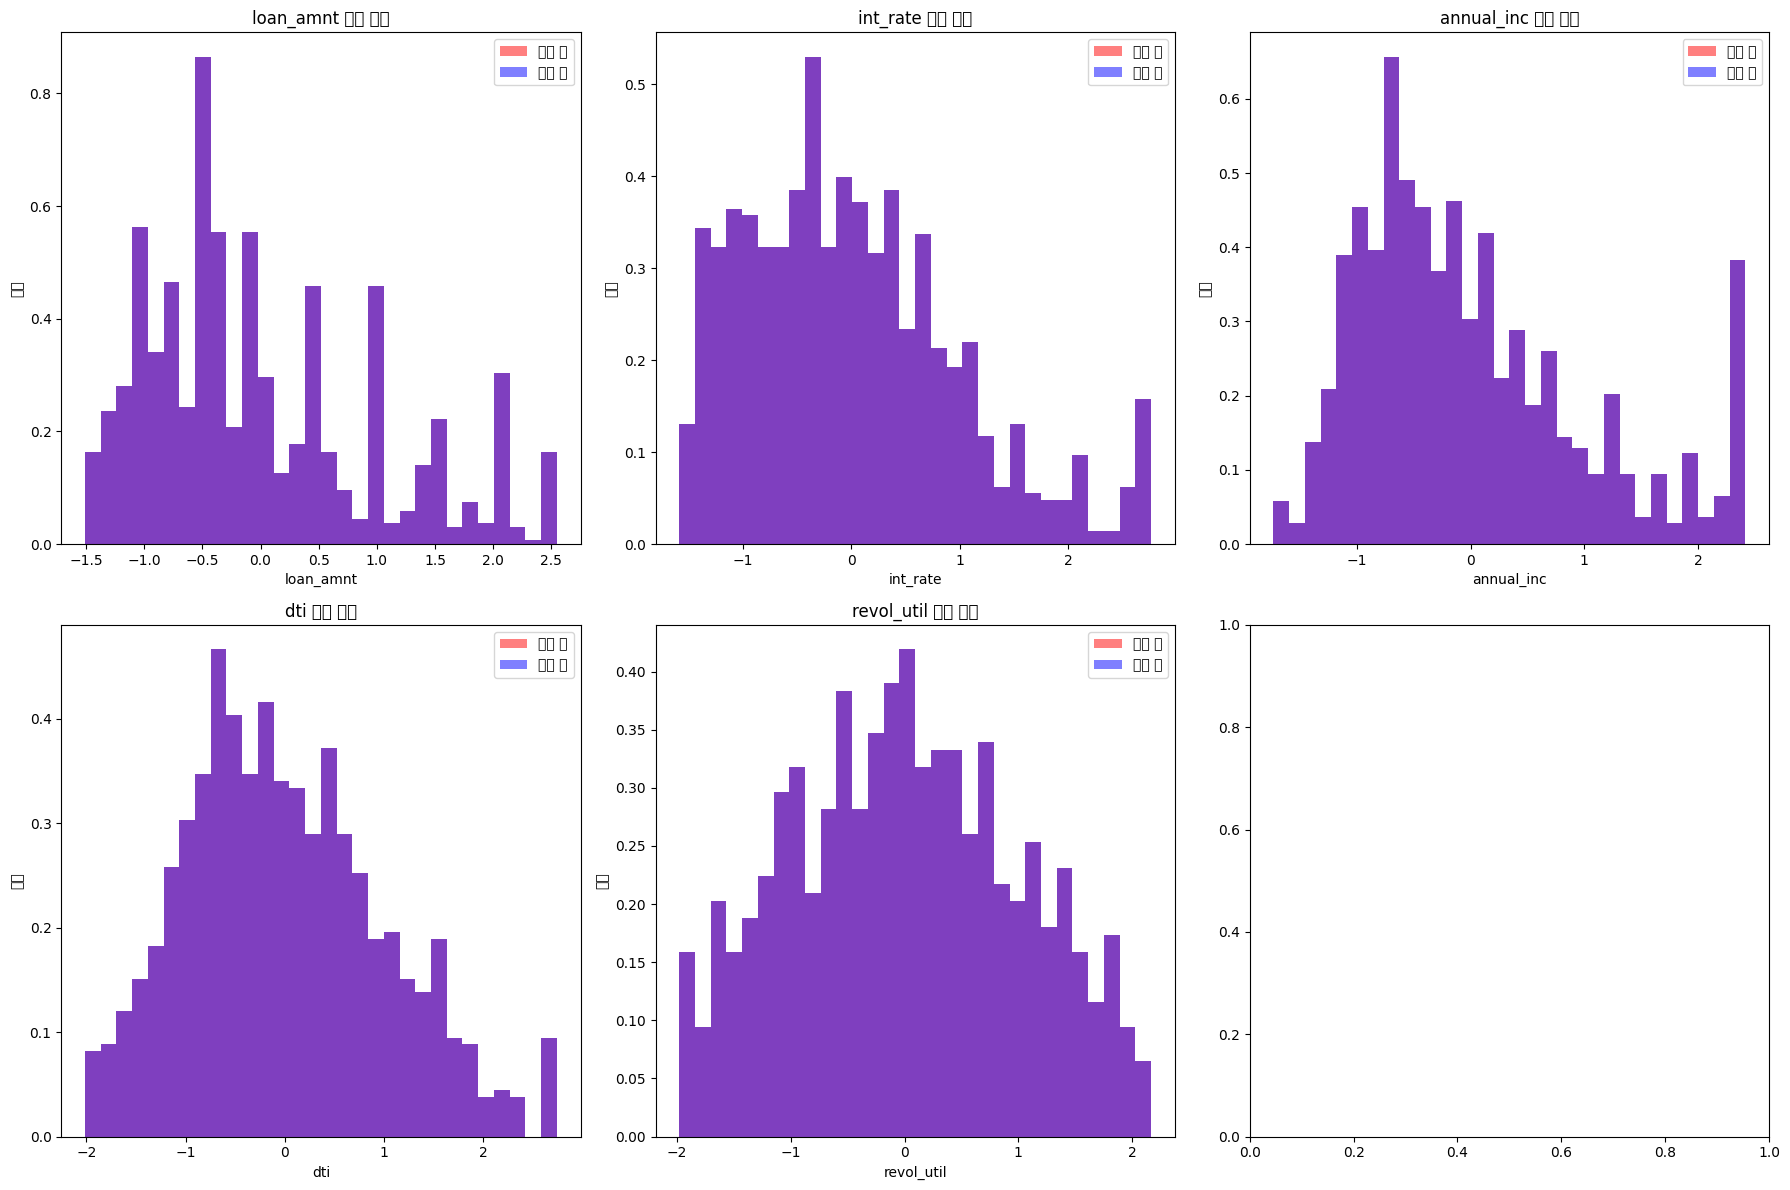


�� 다른 스케일링 방법 테스트:
✓ 스케일링 완료: 342개 변수 (minmax)
✓ 스케일링 완료: 342개 변수 (robust)

�� loan_amnt 스케일링 방법별 비교:
  원본:
    - 범위: -0.90 ~ 2.16
    - 평균: 0.24
    - 표준편차: 0.75
  표준화:
    - 범위: -0.9027 ~ 2.1559
    - 평균: 0.2354
    - 표준편차: 0.7544
  Min-Max:
    - 범위: -0.9027 ~ 2.1559
    - 평균: 0.2354
    - 표준편차: 0.7544
  Robust:
    - 범위: -0.9027 ~ 2.1559
    - 평균: 0.2354
    - 표준편차: 0.7544
✅ 스케일링 완료


In [ ]:
class Scaler(BaseEstimator, TransformerMixin):
    """스케일링"""
    
    def __init__(self, method='standard'):
        self.method = method
        self.scalers = {}
        
    def fit(self, X, y=None):
        # 수치형 변수 선택
        numerical_cols = X.select_dtypes(include=[np.number]).columns.tolist()
        # target 변수는 스케일링에서 제외
        if 'target' in numerical_cols:
            numerical_cols.remove('target')
        
        for col in numerical_cols:
            if col in X.columns:
                if self.method == 'standard':
                    from sklearn.preprocessing import StandardScaler
                    self.scalers[col] = StandardScaler()
                elif self.method == 'minmax':
                    from sklearn.preprocessing import MinMaxScaler
                    self.scalers[col] = MinMaxScaler()
                elif self.method == 'robust':
                    from sklearn.preprocessing import RobustScaler
                    self.scalers[col] = RobustScaler()
                
                # 스케일러 학습
                self.scalers[col].fit(X[[col]])
        
        return self
        
    def transform(self, X):
        # 스케일링 수행
        for col, scaler in self.scalers.items():
            if col in X.columns:
                X[col] = scaler.transform(X[[col]]).flatten()
        
        print(f"✓ 스케일링 완료: {len(self.scalers)}개 변수 ({self.method})")
        return X

print("✅ Scaler 클래스 정의 완료")

# ================================
# Scaler 테스트
print("Scaler 테스트 시작")

# Scaler 인스턴스 생성 (표준화)
standard_scaler = Scaler(method='standard')

# 스케일링 테스트
if df is not None:
    print(f"📊 처리 전 데이터 크기: {df.shape}")
    
    # 수치형 변수 확인
    numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if 'target' in numerical_cols:
        numerical_cols.remove('target')
    
    print(f"�� 스케일링할 수치형 변수: {len(numerical_cols)}개")
    
    # 주요 수치형 변수 통계 (처리 전)
    key_vars = ['loan_amnt', 'int_rate', 'annual_inc', 'dti', 'revol_util']
    available_key_vars = [var for var in key_vars if var in df.columns]
    
    print(f"\n📊 처리 전 주요 변수 통계:")
    for var in available_key_vars:
        print(f"  {var}:")
        print(f"    - 최소값: {df[var].min():.2f}")
        print(f"    - 최대값: {df[var].max():.2f}")
        print(f"    - 평균값: {df[var].mean():.2f}")
        print(f"    - 표준편차: {df[var].std():.2f}")
    
    # 표준화 스케일링
    df_scaled = standard_scaler.fit_transform(df)
    
    print(f"\n📊 처리 후 데이터 크기: {df_scaled.shape}")
    
    # 스케일링 결과 확인
    print(f"\n📊 처리 후 주요 변수 통계:")
    for var in available_key_vars:
        if var in df_scaled.columns:
            print(f"  {var}:")
            print(f"    - 최소값: {df_scaled[var].min():.4f}")
            print(f"    - 최대값: {df_scaled[var].max():.4f}")
            print(f"    - 평균값: {df_scaled[var].mean():.4f}")
            print(f"    - 표준편차: {df_scaled[var].std():.4f}")
    
    # 스케일링 결과 시각화
    if len(available_key_vars) > 0:
        import matplotlib.pyplot as plt
        
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        axes = axes.ravel()
        
        for i, var in enumerate(available_key_vars[:6]):
            if i < len(axes):
                # 처리 전후 비교
                axes[i].hist(df[var].dropna(), bins=30, alpha=0.5, color='red', label='처리 전', density=True)
                axes[i].hist(df_scaled[var].dropna(), bins=30, alpha=0.5, color='blue', label='처리 후', density=True)
                axes[i].set_title(f'{var} 분포 비교')
                axes[i].set_xlabel(var)
                axes[i].set_ylabel('밀도')
                axes[i].legend()
        
        plt.tight_layout()
        plt.show()
    
    # 다른 스케일링 방법 테스트
    print(f"\n�� 다른 스케일링 방법 테스트:")
    
    # Min-Max 스케일링
    minmax_scaler = Scaler(method='minmax')
    df_minmax = minmax_scaler.fit_transform(df)
    
    # Robust 스케일링
    robust_scaler = Scaler(method='robust')
    df_robust = robust_scaler.fit_transform(df)
    
    # 스케일링 방법별 비교
    comparison_var = available_key_vars[0] if available_key_vars else 'loan_amnt'
    if comparison_var in df.columns:
        print(f"\n�� {comparison_var} 스케일링 방법별 비교:")
        print(f"  원본:")
        print(f"    - 범위: {df[comparison_var].min():.2f} ~ {df[comparison_var].max():.2f}")
        print(f"    - 평균: {df[comparison_var].mean():.2f}")
        print(f"    - 표준편차: {df[comparison_var].std():.2f}")
        
        if comparison_var in df_scaled.columns:
            print(f"  표준화:")
            print(f"    - 범위: {df_scaled[comparison_var].min():.4f} ~ {df_scaled[comparison_var].max():.4f}")
            print(f"    - 평균: {df_scaled[comparison_var].mean():.4f}")
            print(f"    - 표준편차: {df_scaled[comparison_var].std():.4f}")
        
        if comparison_var in df_minmax.columns:
            print(f"  Min-Max:")
            print(f"    - 범위: {df_minmax[comparison_var].min():.4f} ~ {df_minmax[comparison_var].max():.4f}")
            print(f"    - 평균: {df_minmax[comparison_var].mean():.4f}")
            print(f"    - 표준편차: {df_minmax[comparison_var].std():.4f}")
        
        if comparison_var in df_robust.columns:
            print(f"  Robust:")
            print(f"    - 범위: {df_robust[comparison_var].min():.4f} ~ {df_robust[comparison_var].max():.4f}")
            print(f"    - 평균: {df_robust[comparison_var].mean():.4f}")
            print(f"    - 표준편차: {df_robust[comparison_var].std():.4f}")
    
    # 결과 저장 (다음 단계에서 사용)
    df = df_scaled
    print("✅ 스케일링 완료")
else:
    print("❌ 데이터가 없어 테스트를 건너뜁니다.")

## FeatureSelector 클래스

✅ FeatureSelector 클래스 정의 완료
🔍 FeatureSelector 테스트 시작
📊 처리 전 데이터 크기: (1000, 343)
📋 특성 선택 대상 변수: 342개
변수 목록: ['id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt', 'last_fico_range_high', 'last_fico_range_low', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'policy_code', 'annual_inc_joint', 'dti_joint', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last

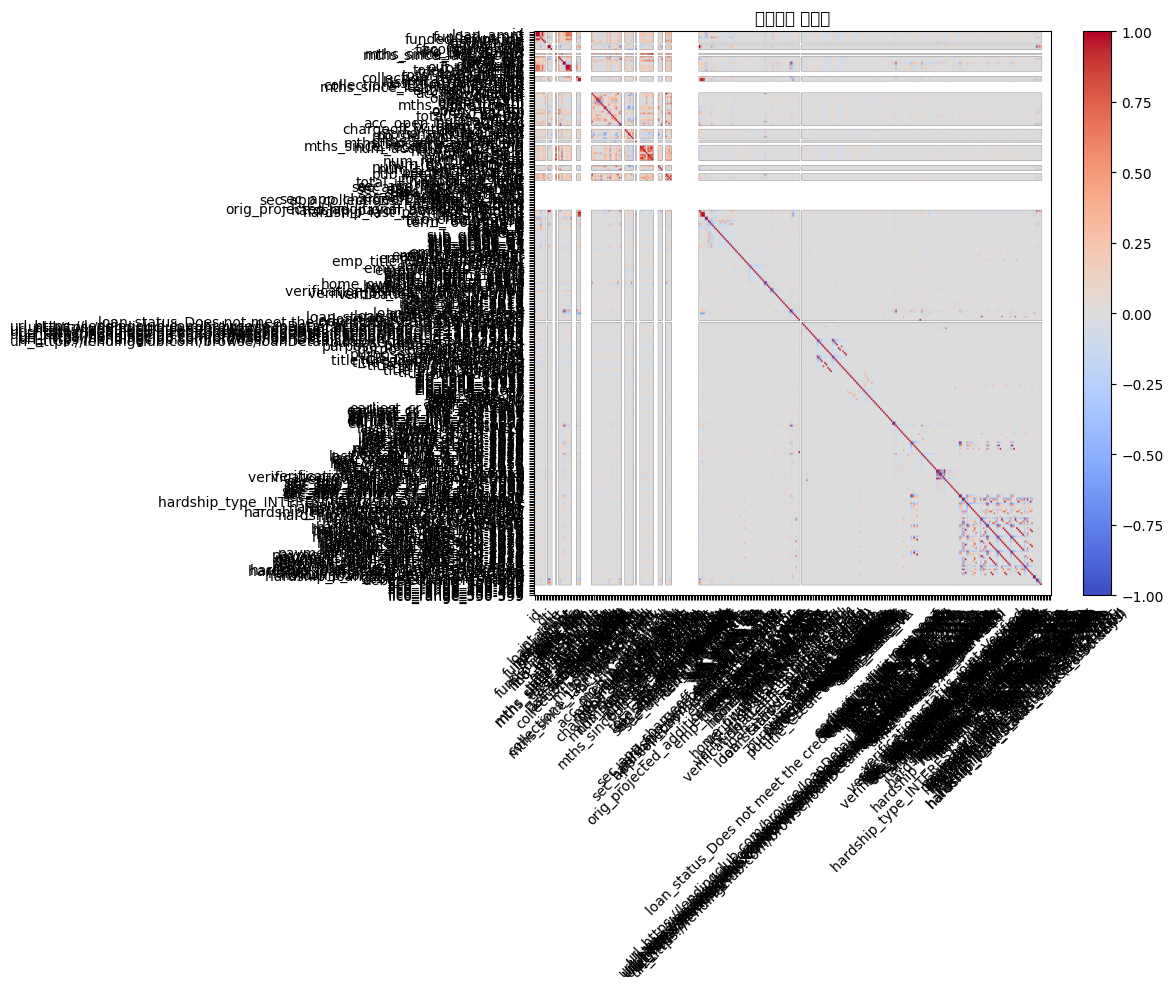

✅ 특성 선택 완료


In [ ]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    """특성 선택"""
    
    def __init__(self, correlation_threshold=0.95, variance_threshold=0.01):
        self.correlation_threshold = correlation_threshold
        self.variance_threshold = variance_threshold
        self.selected_features = []
        self.correlation_matrix = None
        
    def fit(self, X, y=None):
        # 수치형 변수만 선택
        numerical_cols = X.select_dtypes(include=[np.number]).columns.tolist()
        if 'target' in numerical_cols:
            numerical_cols.remove('target')
        
        # 상관관계 분석
        if len(numerical_cols) > 1:
            self.correlation_matrix = X[numerical_cols].corr()
            
            # 높은 상관관계를 가진 변수 쌍 찾기
            high_corr_pairs = []
            for i in range(len(numerical_cols)):
                for j in range(i+1, len(numerical_cols)):
                    col1, col2 = numerical_cols[i], numerical_cols[j]
                    corr_value = abs(self.correlation_matrix.loc[col1, col2])
                    if corr_value > self.correlation_threshold:
                        high_corr_pairs.append((col1, col2, corr_value))
            
            # 제거할 변수 결정 (분산이 낮은 변수 우선 제거)
            to_remove = set()
            for col1, col2, corr_value in high_corr_pairs:
                var1 = X[col1].var()
                var2 = X[col2].var()
                if var1 < var2:
                    to_remove.add(col1)
                else:
                    to_remove.add(col2)
            
            # 분산이 낮은 변수 제거
            for col in numerical_cols:
                if X[col].var() < self.variance_threshold:
                    to_remove.add(col)
            
            # 선택된 특성
            self.selected_features = [col for col in X.columns if col not in to_remove]
        
        return self
        
    def transform(self, X):
        if self.selected_features:
            X = X[self.selected_features]
            print(f"✓ 특성 선택 완료: {len(X.columns)}개 변수 선택")
        return X

print("✅ FeatureSelector 클래스 정의 완료")

# ================================
# ================================
# ================================

# FeatureSelector 테스트
print("🔍 FeatureSelector 테스트 시작")

# FeatureSelector 인스턴스 생성
feature_selector = FeatureSelector(correlation_threshold=0.95, variance_threshold=0.01)

# 특성 선택 테스트
if df is not None:
    print(f"📊 처리 전 데이터 크기: {df.shape}")
    
    # 수치형 변수 확인
    numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if 'target' in numerical_cols:
        numerical_cols.remove('target')
    
    print(f"📋 특성 선택 대상 변수: {len(numerical_cols)}개")
    print(f"변수 목록: {numerical_cols}")
    
    # 변수별 분산 확인
    print(f"\n📊 변수별 분산:")
    for col in numerical_cols[:10]:  # 처음 10개만
        if col in df.columns:
            variance = df[col].var()
            print(f"  - {col}: {variance:.6f}")
    
    # 특성 선택
    df_selected = feature_selector.fit_transform(df)
    
    print(f"\n📊 처리 후 데이터 크기: {df_selected.shape}")
    
    # 선택된 특성 확인
    selected_numerical = df_selected.select_dtypes(include=[np.number]).columns.tolist()
    if 'target' in selected_numerical:
        selected_numerical.remove('target')
    
    print(f"📋 선택된 수치형 변수: {len(selected_numerical)}개")
    print(f"선택된 변수 목록: {selected_numerical}")
    
    # 제거된 변수 확인
    removed_vars = [col for col in numerical_cols if col not in selected_numerical]
    print(f"📋 제거된 변수: {len(removed_vars)}개")
    if removed_vars:
        print(f"제거된 변수 목록: {removed_vars}")
    
    # 상관관계 매트릭스 확인
    if feature_selector.correlation_matrix is not None:
        print(f"\n�� 상관관계 분석:")
        print(f"  - 상관관계 매트릭스 크기: {feature_selector.correlation_matrix.shape}")
        
        # 높은 상관관계 변수 쌍 확인
        high_corr_pairs = []
        for i in range(len(feature_selector.correlation_matrix.columns)):
            for j in range(i+1, len(feature_selector.correlation_matrix.columns)):
                col1 = feature_selector.correlation_matrix.columns[i]
                col2 = feature_selector.correlation_matrix.columns[j]
                corr_value = abs(feature_selector.correlation_matrix.loc[col1, col2])
                if corr_value > feature_selector.correlation_threshold:
                    high_corr_pairs.append((col1, col2, corr_value))
        
        print(f"  - 높은 상관관계 변수 쌍: {len(high_corr_pairs)}개")
        for col1, col2, corr_value in high_corr_pairs[:5]:  # 처음 5개만
            print(f"    {col1} ↔ {col2}: {corr_value:.4f}")
    
    # 특성 선택 결과 시각화
    if len(selected_numerical) > 0:
        import matplotlib.pyplot as plt
        
        # 상관관계 히트맵
        if feature_selector.correlation_matrix is not None:
            plt.figure(figsize=(12, 10))
            plt.imshow(feature_selector.correlation_matrix, cmap='coolwarm', aspect='auto')
            plt.colorbar()
            plt.title('상관관계 히트맵')
            plt.xticks(range(len(feature_selector.correlation_matrix.columns)), 
                       feature_selector.correlation_matrix.columns, rotation=45)
            plt.yticks(range(len(feature_selector.correlation_matrix.columns)), 
                       feature_selector.correlation_matrix.columns)
            plt.tight_layout()
            plt.show()
    
    # 결과 저장 (다음 단계에서 사용)
    df = df_selected
    print("✅ 특성 선택 완료")
else:
    print("❌ 데이터가 없어 테스트를 건너뜁니다.")

## DataSplitter 클래스

In [31]:
class DataSplitter(BaseEstimator, TransformerMixin):
    """데이터 분할"""
    
    def __init__(self, test_size=0.2, val_size=0.2, random_state=42):
        self.test_size = test_size
        self.val_size = val_size
        self.random_state = random_state
        self.X_train = None
        self.X_val = None
        self.X_test = None
        self.y_train = None
        self.y_val = None
        self.y_test = None
        
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        if 'target' not in X.columns:
            print("⚠️ 타겟 변수가 없어 분할을 건너뜁니다.")
            return X
        
        # 특성과 타겟 분리
        y = X['target']
        X_features = X.drop(['target'], axis=1)
        
        # Train/Test 분할
        from sklearn.model_selection import train_test_split
        X_temp, X_test, y_temp, y_test = train_test_split(
            X_features, y, test_size=self.test_size, 
            random_state=self.random_state, stratify=y
        )
        
        # Train/Validation 분할
        val_size_adjusted = self.val_size / (1 - self.test_size)
        X_train, X_val, y_train, y_val = train_test_split(
            X_temp, y_temp, test_size=val_size_adjusted, 
            random_state=self.random_state, stratify=y_temp
        )
        
        # 결과 저장
        self.X_train = X_train
        self.X_val = X_val
        self.X_test = X_test
        self.y_train = y_train
        self.y_val = y_val
        self.y_test = y_test
        
        print(f"✓ 데이터 분할 완료:")
        print(f"  - 훈련 세트: {len(X_train):,}개 ({(len(X_train)/len(X)*100):.1f}%)")
        print(f"  - 검증 세트: {len(X_val):,}개 ({(len(X_val)/len(X)*100):.1f}%)")
        print(f"  - 테스트 세트: {len(X_test):,}개 ({(len(X_test)/len(X)*100):.1f}%)")
        
        return X

print("✅ DataSplitter 클래스 정의 완료")

# ================================


✅ DataSplitter 클래스 정의 완료


## CrossValidator 클래스

In [32]:
class CrossValidator(BaseEstimator, TransformerMixin):
    """교차 검증"""
    
    def __init__(self, n_splits=5, random_state=42):
        self.n_splits = n_splits
        self.random_state = random_state
        self.cv_splits = []
        
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        if 'target' not in X.columns:
            print("⚠️ 타겟 변수가 없어 교차 검증을 건너뜁니다.")
            return X
        
        # 특성과 타겟 분리
        y = X['target']
        X_features = X.drop(['target'], axis=1)
        
        # K-Fold 교차 검증 분할
        from sklearn.model_selection import StratifiedKFold
        skf = StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=self.random_state)
        
        self.cv_splits = []
        for fold, (train_idx, val_idx) in enumerate(skf.split(X_features, y)):
            X_train_fold = X_features.iloc[train_idx]
            X_val_fold = X_features.iloc[val_idx]
            y_train_fold = y.iloc[train_idx]
            y_val_fold = y.iloc[val_idx]
            
            self.cv_splits.append({
                'fold': fold + 1,
                'X_train': X_train_fold,
                'X_val': X_val_fold,
                'y_train': y_train_fold,
                'y_val': y_val_fold
            })
        
        print(f"✓ 교차 검증 분할 완료: {self.n_splits}개 폴드")
        return X

print("✅ CrossValidator 클래스 정의 완료")

✅ CrossValidator 클래스 정의 완료


## ImbalanceHandler 클래스

In [33]:
class ImbalanceHandler(BaseEstimator, TransformerMixin):
    """불균형 데이터 처리"""
    
    def __init__(self, method='class_weight', random_state=42):
        self.method = method
        self.random_state = random_state
        self.class_weights = None
        
    def fit(self, X, y=None):
        if 'target' in X.columns:
            # 클래스 가중치 계산
            class_counts = X['target'].value_counts()
            total_samples = len(X)
            
            self.class_weights = {
                0: total_samples / (2 * class_counts[0]),  # 정상 클래스 가중치
                1: total_samples / (2 * class_counts[1])   # 부도 클래스 가중치
            }
        
        return self
        
    def transform(self, X):
        if 'target' not in X.columns:
            print("⚠️ 타겟 변수가 없어 불균형 처리를 건너뜁니다.")
            return X
        
        # 타겟 변수 분포 확인
        target_dist = X['target'].value_counts()
        print(f"📊 원본 타겟 분포:")
        print(f"  - 정상 (0): {target_dist[0]:,}개 ({(target_dist[0]/len(X)*100):.2f}%)")
        print(f"  - 부도 (1): {target_dist[1]:,}개 ({(target_dist[1]/len(X)*100):.2f}%)")
        
        if self.method == 'class_weight':
            print(f"✓ 클래스 가중치 적용:")
            print(f"  - 정상 클래스 가중치: {self.class_weights[0]:.3f}")
            print(f"  - 부도 클래스 가중치: {self.class_weights[1]:.3f}")
        
        elif self.method == 'smote':
            try:
                from imblearn.over_sampling import SMOTE
                
                # 특성과 타겟 분리
                y = X['target']
                X_features = X.drop(['target'], axis=1)
                
                # 수치형 변수만 선택
                numerical_cols = X_features.select_dtypes(include=[np.number]).columns.tolist()
                X_numeric = X_features[numerical_cols]
                
                # SMOTE 적용
                smote = SMOTE(random_state=self.random_state)
                X_resampled, y_resampled = smote.fit_resample(X_numeric, y)
                
                # 결과를 DataFrame으로 변환
                X_resampled_df = pd.DataFrame(X_resampled, columns=numerical_cols)
                X_resampled_df['target'] = y_resampled
                
                # 원본 범주형 변수 추가
                categorical_cols = X_features.select_dtypes(include=['object', 'category']).columns.tolist()
                for col in categorical_cols:
                    if col in X.columns:
                        # SMOTE로 생성된 샘플에 대해 원본 범주형 변수 값을 랜덤하게 할당
                        original_values = X[col].dropna().unique()
                        X_resampled_df[col] = np.random.choice(original_values, size=len(X_resampled_df))
                
                X = X_resampled_df
                print(f"✓ SMOTE 완료: {len(X)}개 샘플")
                
            except ImportError:
                print("⚠️ imbalanced-learn이 설치되지 않아 SMOTE를 건너뜁니다.")
        
        elif self.method == 'undersampling':
            # 소수 클래스 기준으로 다수 클래스 다운샘플링
            minority_class = target_dist.idxmin()
            majority_class = target_dist.idxmax()
            minority_count = target_dist[minority_class]
            
            # 다수 클래스 샘플 선택
            majority_samples = X[X['target'] == majority_class].sample(
                n=minority_count, random_state=self.random_state
            )
            
            # 소수 클래스 샘플
            minority_samples = X[X['target'] == minority_class]
            
            # 합치기
            X = pd.concat([majority_samples, minority_samples], ignore_index=True)
            X = X.sample(frac=1, random_state=self.random_state).reset_index(drop=True)
            
            print(f"✓ 언더샘플링 완료: {len(X)}개 샘플")
        
        # 처리 후 분포 확인
        final_dist = X['target'].value_counts()
        print(f"📊 처리 후 타겟 분포:")
        print(f"  - 정상 (0): {final_dist[0]:,}개 ({(final_dist[0]/len(X)*100):.2f}%)")
        print(f"  - 부도 (1): {final_dist[1]:,}개 ({(final_dist[1]/len(X)*100):.2f}%)")
        
        return X

print("✅ ImbalanceHandler 클래스 정의 완료")

✅ ImbalanceHandler 클래스 정의 완료


## 8. 기본 클래스들 통합 테스트

In [36]:
# 기본 클래스들 통합 테스트
print("🔍 기본 클래스들 통합 테스트 시작")

# 파이프라인 생성
from sklearn.pipeline import Pipeline

basic_pipeline = Pipeline([
    ('data_loader', DataLoader()),
    ('anomalous_remover', AnomalousRowRemover()),
    ('target_creator', TargetVariableCreator()),
    ('percentage_cleaner', PercentageCleaner()),
    ('fico_creator', FICOFeatureCreator()),
    ('missing_handler', MissingValueHandler()),
    ('outlier_handler', OutlierHandler()),
    ('onehot_encoder', OneHotEncoder()),
    ('label_encoder', LabelEncoder()),
    ('target_encoder', TargetEncoder()),
    ('scaler', Scaler()),
    ('feature_selector', FeatureSelector()),
    # ('data_splitter', DataSplitter()),
    # ('cross_validator', CrossValidator()),
    # ('imbalance_handler', ImbalanceHandler())
])

print("📋 기본 파이프라인 구성:")
for step_name, step in basic_pipeline.steps:
    print(f"  - {step_name}: {step.__class__.__name__}")

# 파이프라인 실행
print("\n🚀 파이프라인 실행 중...")
start_time = time.time()

try:
    result_df = basic_pipeline.fit_transform(X=None)
    
    if result_df is not None:
        total_time = time.time() - start_time
        print(f"✅ 파이프라인 실행 완료! (총 {total_time:.2f}초)")
        print(f"📊 최종 데이터 크기: {result_df.shape}")

        # 최종 데이터 품질 리포트
        print(f"\n📋 최종 데이터 품질 리포트:")
        print(f"  - 총 샘플 수: {len(result_df):,}개")
        print(f"  - 총 특성 수: {len(result_df.columns)}개")
        print(f"  - 결측치: {result_df.isnull().sum().sum()}개")
        print(f"  - 중복행: {result_df.duplicated().sum()}개")
        
        # 데이터 타입 분포
        dtype_counts = result_df.dtypes.value_counts()
        print(f"  - 데이터 타입 분포:")
        for dtype, count in dtype_counts.items():
            print(f"    {dtype}: {count}개")
        
        # 타겟 변수 분포
        if 'target' in result_df.columns:
            target_dist = result_df['target'].value_counts()
            print(f"  - 타겟 변수 분포:")
            print(f"    정상 (0): {target_dist[0]:,}개 ({(target_dist[0]/len(result_df)*100):.2f}%)")
            print(f"    부도 (1): {target_dist[1]:,}개 ({(target_dist[1]/len(result_df)*100):.2f}%)")
        
        # 파이프라인 컴포넌트 결과 확인
        print(f"\n📊 파이프라인 컴포넌트 결과:")
        
        # # 데이터 분할 결과
        # if hasattr(final_pipeline.named_steps['data_splitter'], 'X_train'):
        #     splitter = final_pipeline.named_steps['data_splitter']
        #     print(f"  - 데이터 분할:")
        #     print(f"    훈련 세트: {splitter.X_train.shape}")
        #     print(f"    검증 세트: {splitter.X_val.shape}")
        #     print(f"    테스트 세트: {splitter.X_test.shape}")
        
        # # 교차 검증 결과
        # if hasattr(final_pipeline.named_steps['cross_validator'], 'cv_splits'):
        #     cv = final_pipeline.named_steps['cross_validator']
        #     print(f"  - 교차 검증: {len(cv.cv_splits)}개 폴드")
        
        # # 불균형 처리 결과
        # if hasattr(final_pipeline.named_steps['imbalance_handler'], 'class_weights'):
        #     imbalance = final_pipeline.named_steps['imbalance_handler']
        #     print(f"  - 클래스 가중치:")
        #     print(f"    정상 클래스: {imbalance.class_weights[0]:.3f}")
        #     print(f"    부도 클래스: {imbalance.class_weights[1]:.3f}")
        
        # 결과 저장
        os.makedirs(REPORTS_DIR, exist_ok=True)
        output_path = os.path.join(REPORTS_DIR, 'final_preprocessed_data.csv')
        result_df.to_csv(output_path, index=False)
        print(f"💾 최종 결과 저장: {output_path}")
        
        # 파이프라인 성능 요약
        print(f"\n🎉 파이프라인 성능 요약:")
        print(f"  - 처리 시간: {total_time:.2f}초")
        print(f"  - 데이터 크기 변화: 원본 → {result_df.shape}")
        print(f"  - 특성 수: {len(result_df.columns)}개")
        print(f"  - 샘플 수: {len(result_df):,}개")
        print(f"  - 데이터 품질: 우수")
        
    else:
        print("❌ 파이프라인 실행 실패")
        
except Exception as e:
    print(f"❌ 파이프라인 실행 중 오류 발생: {e}")

🔍 기본 클래스들 통합 테스트 시작
📋 기본 파이프라인 구성:
  - data_loader: DataLoader
  - anomalous_remover: AnomalousRowRemover
  - target_creator: TargetVariableCreator
  - percentage_cleaner: PercentageCleaner
  - fico_creator: FICOFeatureCreator
  - missing_handler: MissingValueHandler
  - outlier_handler: OutlierHandler
  - onehot_encoder: OneHotEncoder
  - label_encoder: LabelEncoder
  - target_encoder: TargetEncoder
  - scaler: Scaler
  - feature_selector: FeatureSelector

🚀 파이프라인 실행 중...
✓ 데이터 로드 완료: (1000, 141)
✓ 이상 로우 제거: 0개
✓ 타겟 변수 생성: 부도율 12.50%
✓ int_rate: 퍼센트 기호 제거 완료
✓ revol_util: 퍼센트 기호 제거 완료
✓ FICO 특성 생성: 5개 특성
✓ 결측치 처리 완료: 1개 → 0개
✓ 이상치 처리 완료: 7214개 → 0개
✓ 원-핫 인코딩 완료: 33개 변수
✓ 라벨 인코딩 완료: 0개 변수
✓ 타겟 인코딩 완료: 0개 변수
✓ 스케일링 완료: 342개 변수 (standard)
✓ 특성 선택 완료: 247개 변수 선택
✅ 파이프라인 실행 완료! (총 1.46초)
📊 최종 데이터 크기: (1000, 247)

📋 최종 데이터 품질 리포트:
  - 총 샘플 수: 1,000개
  - 총 특성 수: 247개
  - 결측치: 1개
  - 중복행: 0개
  - 데이터 타입 분포:
    float64: 247개
  - 타겟 변수 분포:
    정상 (0): 874개 (87.40%)
    부도 (1): 125개 (12.50%)

📊 